Image captioning is a task to describe the image. For example, `a surfer riding on a wave` is generated given the below image.

![](https://tensorflow.org/images/surf.jpg)

License: Public Domain

To accomplish this goal, you'll use an `attention-based model`. It would help us to take a look at what parts of the image that the model focuses on when it generates the caption.

![](https://tensorflow.org/images/imcap_prediction.png)

Refer to Tensorflow.Org (2020)

The model used here is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

In [0]:
!pip install -q tf-nightly tqdm

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output

import re
import numpy as np
import os
import json
from glob import glob
import cv2
import pickle
import tqdm

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200218
GPU is available.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')  # for saving checkpoints

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Preprocessing

You will use the MS-COCO dataset, which contains 82000 images and at least 5 captions for each image.

## Downloading Caption Datasets

In [3]:
annotation_folder = 'annotations'

if not os.path.exists(os.path.join(os.path.abspath('.'), annotation_folder)):
  annotation_zip = tf.keras.utils.get_file(
    'captions.zip', 
    origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', 
    cache_subdir=os.path.abspath('.'),
    extract=True)
  annotation_file = os.path.join(os.path.dirname(annotation_zip), 
                                 'annotations', 
                                 'captions_train2014.json')
  os.remove(annotation_zip)

252878848/252872794 [==============================] - 3s 0us/step


In [4]:
!ls -al /content/annotations/

total 825044
drwxr-xr-x 2 root root      4096 Feb 21 07:18 .
drwxr-xr-x 1 root root      4096 Feb 21 07:18 ..
-rw-r--r-- 1 root root  66782097 Feb 21 07:18 captions_train2014.json
-rw-r--r-- 1 root root  32421077 Feb 21 07:18 captions_val2014.json
-rw-r--r-- 1 root root 332556225 Feb 21 07:18 instances_train2014.json
-rw-r--r-- 1 root root 160682675 Feb 21 07:18 instances_val2014.json
-rw-r--r-- 1 root root 170733465 Feb 21 07:18 person_keypoints_train2014.json
-rw-r--r-- 1 root root  81637509 Feb 21 07:18 person_keypoints_val2014.json


## Downloading Image Datasets

In [5]:
img_folder = "train2014"

if not os.path.exists(os.path.join(os.path.abspath('.'), img_folder)):
  img_zip = tf.keras.utils.get_file(
    "train2014.zip", 
    origin='http://images.cocodataset.org/zips/train2014.zip',
    cache_subdir=os.path.abspath('.'),
    extract=True)
  PATH = os.path.join(os.path.dirname(img_zip), img_folder)
  os.remove(img_zip)
else:
  PATH = os.path.join(os.path.abspath('.'), img_folder)

13510574080/13510573713 [==============================] - 324s 0us/step


In [6]:
# first several imgs
next(os.walk(PATH))[2][:5]

['COCO_train2014_000000106658.jpg',
 'COCO_train2014_000000305975.jpg',
 'COCO_train2014_000000411446.jpg',
 'COCO_train2014_000000386111.jpg',
 'COCO_train2014_000000033425.jpg']

In [7]:
!ls -al {PATH} | wc -l

82786


## Limit the Size of the Training Dataset

This notebook is an end-to-end example. To speed up the training, we are going to use [MS-COCO](http://cocodataset.org/#home) dataset that we take 30000 captions for 20000 images as the training dataset (An image could have more than 1 caption).

In [0]:
# read the annotations
with open(annotation_file) as fin:
  annotations = json.load(fin)

Let's take a look at the annotation content.

In [9]:
annotations.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [10]:
annotations['annotations'][:5]

[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556},
 {'caption': 'A panoramic photo of a kitchen and dining room',
  'id': 148,
  'image_id': 116100},
 {'caption': 'A graffiti-ed stop sign across the street from a red car ',
  'id': 173,
  'image_id': 379340}]

In [11]:
annotations['images'][:3]

[{'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'date_captured': '2013-11-14 16:28:13',
  'file_name': 'COCO_train2014_000000057870.jpg',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'height': 480,
  'id': 57870,
  'license': 5,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'date_captured': '2013-11-14 16:29:45',
  'file_name': 'COCO_train2014_000000384029.jpg',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'height': 429,
  'id': 384029,
  'license': 5,
  'width': 640},
 {'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg',
  'date_captured': '2013-11-14 16:37:59',
  'file_name': 'COCO_train2014_000000222016.jpg',
  'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg',
  'height': 640,
  'id': 222016,
  'license': 1,
  'width': 480}]

In [0]:
all_captions = []
all_img_names = []

for annot in annotations['annotations']:
  caption = '{} {} {}'.format('<start>', annot['caption'], '<end>')
  image_id = annot['image_id']
  coco_img_path = "{}/COCO_train2014_{:012d}.jpg".format(PATH, image_id)

  all_img_names.append(coco_img_path)
  all_captions.append(caption)

# shuffle captions and image_names together
captions, img_names = shuffle(all_captions, all_img_names, random_state=1)

# select the first 30000 elements as the training dataset
num_examples = 30000
train_caption = captions[:num_examples]
train_img_names = img_names[:num_examples]

In [13]:
for cap, name in zip(train_caption[:3], train_img_names[:3]):
  print("The caption: `{}` in the image `{}`.".format(cap, name))

The caption: `<start> A skateboarder performing a trick on a skateboard ramp. <end>` in the image `/content/train2014/COCO_train2014_000000324909.jpg`.
The caption: `<start> a person soaring through the air on skis <end>` in the image `/content/train2014/COCO_train2014_000000511972.jpg`.
The caption: `<start> a wood door with some boards laid against it <end>` in the image `/content/train2014/COCO_train2014_000000508809.jpg`.


In [14]:
len(all_captions), len(train_caption)

(414113, 30000)

# Preprocessing the Images using InceptionV3

Next, we are going to preprocess the images. We use the pre-trained InceptionV3 on ImageNet to extract features from the last convolutional layer.

The preprocessing includes:
* Resize an image to the shape of `(299, 299)`. This shape is the same as the input of the InceptionV3 model that is further used as the image encoder.
* Normalize an image using the `tf.keras.applications.inception_v3.preprocess_input` API to scale the RGB channel value in the range from -1 to 1.

In [0]:
def load_image(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))

  # normalize the channel value to the range from -1 to 1
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

## Instantiate the InceptionV3 with the Pre-Trained Weights

We use the pre-trained InceptionV3 model. We use its last convolutional layer of the InceptionV3 as the feature extractor. The shape of the layer is (8, 8, 2048). You use the last convolutional layer for the attention mechanism. This layer is also the bottleneck.

* You forward each image through the pre-trained model and store the feature vector in a dictionary `(image_name -> feature_vector)`.
* After all images are passed through the model, save all of the features in a pickle object.

In [16]:
image_model = tf.keras.applications.InceptionV3(
  include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_feature_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 3s 0us/step


## Cached the Features extracted from the InceptionV3

In [17]:
# get unique image names
encoded_train = sorted(set(train_img_names))

image_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm.tqdm(image_dataset):
  batch_features = image_feature_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
  for bottleFeatures, each_path in zip(batch_features, path):
    path_of_features = each_path.numpy().decode("UTF-8")
    np.save(path_of_features, bottleFeatures.numpy())

1622it [06:31,  3.92it/s]


In [18]:
[item for item in next(os.walk(PATH))[2] if item[-3:] == "npy"][:10]

['COCO_train2014_000000478809.jpg.npy',
 'COCO_train2014_000000136092.jpg.npy',
 'COCO_train2014_000000526840.jpg.npy',
 'COCO_train2014_000000104021.jpg.npy',
 'COCO_train2014_000000294116.jpg.npy',
 'COCO_train2014_000000204667.jpg.npy',
 'COCO_train2014_000000193287.jpg.npy',
 'COCO_train2014_000000014089.jpg.npy',
 'COCO_train2014_000000208940.jpg.npy',
 'COCO_train2014_000000296344.jpg.npy']

# Preprocessing and Tokenizing the Captions

Next, we are going to preprocess the captions into tokens. There are several steps:

* Tokenize the caption into tokens. For example, the tokens are like `man`, `surfing`, etc.
* Limit the token (or vocabulary) size up to 5000 to save the memory. The other words are replaced with 'UNK' (unknown).
* Create both word-to-index and index-to-word mappings.
* Pad the sequence of tokens into the same length (the same as the longest sequence by default).

In [0]:
# find the longest sequence length of the batch tensors
def longest_length(tensor):
  return max([len(t) for t in tensor])

In [0]:
# choose the top 5K words from the vocabularies
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(
  num_words=top_k, oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

# generate the token list
tokenizer.fit_on_texts(train_caption)

# convert the sequence to the tokenized vectors (token number)
train_seqs = tokenizer.texts_to_sequences(train_caption)

# pad the sequence
pad_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding="post")

In [21]:
pad_seqs.shape, pad_seqs[:2]

((30000, 49),
 array([[   3,    2,  351,  687,    2,  280,    5,    2,   84,  339,    4,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [   3,    2,   31, 2356,  112,    7,  137,    5,  159,    4,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0]], dtype=int32))

In [0]:
# tokens start from 1, set <pad> to 0
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [23]:
# calculate the max_length of the sequence, it is used to store attention weights
max_length = longest_length(train_seqs)
assert max_length == len(pad_seqs[0])
print(max_length)

49


# Splitting the Dataset into the Training and Testing

In [24]:
img_name_train, img_name_val, pad_train, pad_val = train_test_split(
  train_img_names, pad_seqs, test_size=0.2, random_state=0)

len(img_name_train), len(img_name_val), len(pad_train), len(pad_val)

(24000, 6000, 24000, 6000)

## Create a tf.data.Dataset for Training

Next, when the images and captions are prepared, we now can create a `tf.data.Dataset` for the training.

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps_per_epoch = len(img_name_train) // BATCH_SIZE

In [0]:
# shape of the vector extracted from InceptionV3 is (8x8, 2048)
# these two variables represent that vector shape
feature_shape = 2048
attention_features_shape = 64

In [0]:
# load the numpy files which extracted features from InceptionV3
def map_func(img_path, pad):
  img_tensor = np.load("{}.npy".format(img_path.decode("UTF-8")))
  return img_tensor, pad

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, pad_train))

# load the image tensor
dataset = dataset.map(
  lambda item1, item2: 
    tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32])
)

# shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).prefetch(tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

clear_output()
for _data in dataset.take(1):
  print("Image Shape (batch_size, 8x8 (InceptionV3[1]xInceptionV3[2]), 2048 (InceptionV3[3])): {}".format(_data[0].shape))
  print("Padded Sequence (batch_size, padded_sequence_length): {}".format(_data[1].shape))

Image Shape (batch_size, 8x8 (InceptionV3[1]xInceptionV3[2]), 2048 (InceptionV3[3])): (64, 64, 2048)
Padded Sequence (batch_size, padded_sequence_length): (64, 49)


# Model

The model of image captioning is similar to the seq2seq one which is composed of an encoder and a decoder. The decoder one is identical to the one in the seq2seq model, which is a gated RNN cell empowered by an attention mechanism. The encoder is a modified pre-trained InceptionV3 model and generates convolutional features.

The model architecture of image captioning is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this mode, you extract the image features from the last convolutional layer of a pre-trained InceptionV3 model giving us a vector in shape (8, 8, 2048).
* You further squash the vector into the shape of (8x8, 2048). You can regard the squashed vector as time-series data in the shape of (timestamp, features).
* The squashed vector is further passed through a CNN encoder (here it consists of a single dense layer).
* The gated RNN attends over the image to predict the next word.

## Building the Model

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    """
    Args:
      units: the number for the potential timestamp
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    """
    Args:
      features: the encoder output in the shape of 
                (batch_size, sequence_length, hidden_size == encoder_units)
      hidden: the hidden state of the last timestamp in the shape of
              (batch_size, hidden_size == encoder_units)

    Returns:
      context_vector: the context vector in the shape of 
                      (batch_size, 1, units == hidden_size)
      attention_weights: the attention weights in the shape of
                         (batch_size, sequence_length, 1)
    """
    # (batch_size, 1, hidden_size)
    hidden_state_time_axis = tf.expand_dims(hidden, axis=1)

    # (batch_size, sequence_length == 64, unit)
    weights_vector = tf.nn.tanh(self.W1(features) + self.W2(hidden_state_time_axis))

    # (batch_size, sequence_length == 64, 1)
    attention_weights = tf.nn.softmax(self.V(weights_vector), axis=1)

    # (batch_size, sequence_length, units == hidden_size)
    context_vector = features * attention_weights
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dims):
    super(CNN_Encoder, self).__init__()
    # (batch_size, 64 = 8x8, 2048) => (batch_size, 64, embedding_dims)
    self.dense = tf.keras.layers.Dense(embedding_dim)

  def call(self, x):
    x = self.dense(x)
    x = tf.nn.relu(x)  # output: (batch_size, 64, embedding_dims)
    return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dims, units):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dims)
    self.gru = tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(units)

  def call(self, x, features, hidden):
    # get the information from the Encoder
    # context_vector: (batch_size, units)
    # attention_weights: (batch_size, 1 == sequence_length, 1)
    context_vector, attention_weights = self.attention(features, hidden)

    # get the embedding vector, (batch_size, sequence_length == 1, embedding_dims)
    embed = self.embedding(x)

    # concatenate the features and context, (batch_size, 1, embedding_dims + units)
    concatenate = tf.concat([tf.expand_dims(context_vector, axis=1), embed], axis=-1)

    # output: (batch_size, 1, units)
    # state: (batch_size, hidden_size)
    output, state = self.gru(concatenate)

    # (batch_size, 1, hidden_size == units)
    fc1 = self.fc1(output)

    # reshape the fc1 to (batch_size * sequence_length, hidden_size)
    # we want to connect the hidden with the vocab_size
    x = tf.reshape(fc1, (-1, fc1.shape[2]))

    # (batch_size * sequence_length, vocab_size)
    vocab = self.fc2(x)

    return vocab, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(vocab_size, embedding_dim, units)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
  from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_mean(loss)

## Checkpoint

In [0]:
ckpt_path = "./ckpt/train"
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restore the latest checkpoint in ckpt_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* Pass the extracted features through the encoder from the `.npy` file and get the encoder output `(batch_size, 64, 2048)` and the hidden state `(batch_size, embedding_dim)`.
* Pass the decoder input which is a start token in shape (batch_size, 1), the encoder output, and the encoder hidden state which is as the initial decoder state into the decoder.
* The decoder returns the predictions and the decoder state. The decoder state is further passed back into the decoder and the predictions are used to calculate the loss.
* In decoder training, use teacher forcing to decide the next input token to the decoder.
* Calculate the gradients given the loss and apply to the variable using the backpropagate.

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(images, targets):
  """
  Args:
    images: (batch_size, 64, 2048)
    targets: (batch_size, padded_sequence_length)

  Returns:
    total_loss: the total loss 
    loss: total / batch_size
  """
  total_loss = 0

  # initializing the hidden state on every batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=targets.shape[0])

  # the start token for the decoder, (batch_size, 1)
  dec_inputs = tf.expand_dims([tokenizer.word_index['<start>']] * targets.shape[0], axis=1)

  with tf.GradientTape() as tape:
    # features == encoder_output in shape (64, embedding_dims)
    features = encoder(images)

    for t in range(1, targets.shape[1]):
      # vocab: (batch_size * sequence_length, vocab_size)
      vocab, hidden, attention_weights = decoder(dec_inputs, features, hidden)

      # total loss is the sum along the time axis
      total_loss += loss_function(targets[:, t], vocab)

      # teacher forcing
      dec_inputs = tf.expand_dims(targets[:, t], axis=1)
  
  # average loss along time axis
  loss = total_loss / int(targets.shape[1])
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(total_loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return total_loss, loss

In [57]:
START_EPOCH = 0
EPOCHS = 20

loss_history = []

for epoch in range(START_EPOCH, EPOCHS):
  total_loss = 0.0

  for batch, (images, sequences) in enumerate(dataset): 
    # get the batch loss and the time-series loss of the batch loss
    batch_total_loss, time_loss = train_step(images, sequences)
    total_loss += time_loss

    if batch % 100 == 0:
      print("Epoch {}, Batch {}, Batch_Loss {:.8f}".format(epoch+1, batch, time_loss))

  epoch_loss = total_loss / batch
  loss_history.append(epoch_loss)

  if epoch % 5 == 0:
    ckpt_manager.save()

  print("Epoch: {}, Epoch Loss: {:.8f}".format(epoch+1, epoch_loss))

Epoch 18, Batch 200, Loss 0.26982018
Epoch 18, Batch 300, Loss 0.29293090
Epoch: 17, Epoch Loss: 0.29865655
Epoch 19, Batch 0, Loss 0.28283918
Epoch 19, Batch 100, Loss 0.28289935
Epoch 19, Batch 200, Loss 0.28469875
Epoch 19, Batch 300, Loss 0.27943051
Epoch: 18, Epoch Loss: 0.27991861
Epoch 20, Batch 0, Loss 0.25334436
Epoch 20, Batch 100, Loss 0.27258274
Epoch 20, Batch 200, Loss 0.25415236
Epoch 20, Batch 300, Loss 0.24588595
Epoch: 19, Epoch Loss: 0.26398703


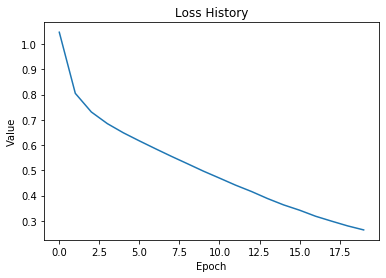

In [65]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Loss History")
plt.show()

# Caption

* The evaluation function is similar to the training loop but without the teacher forcing method. The decoder input at each time is the previous prediction along with the previous state and the encoder output.
* Stop prediction while the decoder prediction is the end token.
* Store the attention weights for every time step.

In [80]:
tf.expand_dims(load_image(image_path)[0], axis=0).shape

TensorShape([1, 299, 299, 3])

In [0]:
def evaluate(image):
  """
  Args:
    image: the image path

  Returns:
    result
    attention_plots
  """
  # save attentions
  attention_plot = np.zeros((max_length, attention_features_shape))

  # decoder initialization
  hidden = decoder.reset_state(batch_size=1)

  # image preprocessing and feature extraction using the encoder
  img = tf.expand_dims(load_image(image)[0], axis=0)
  features = image_feature_extract_model(img)
  features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))  # (batch_size, 64, 2048)

  # (batch_size = 1, 64, embedding_dims)
  enc_output = encoder(features)

  # start from a start token
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], axis=0)

  # save the results
  result = []

  for t in range(0, max_length):
    # generate the vocab, hidden state and the attention weights
    vocab, hidden, attention_weights = decoder(dec_input, enc_output, hidden)

    # save the attention weights
    attention_plot[t] = tf.reshape(attention_weights, (-1, )).numpy()

    # get the prediction vocabulary
    predicted_id = tf.random.categorical(vocab, 1)[0][0].numpy()
    token = tokenizer.index_word[predicted_id]
    result.append(token)

    if token == "<end>":
      break

    # for the next input
    dec_input = tf.expand_dims([predicted_id], axis=0)

  attention_plot = attention_plot[:len(result), :]
  return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
  temp_img = cv2.imread(image)

  fig = plt.figure(figsize=(10, 10))
  
  result_length = len(result)
  for l in range(result_length):
    attentions = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(result_length // 2, result_length // 2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_img)
    ax.imshow(attentions, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

Validate the model on the validation data.

Real: <start> a fire hydrant on the side walk next to some buildings <end>
Prediction: ['a', 'park', 'area', 'shows', 'a', 'professional', 'pool', '<end>']


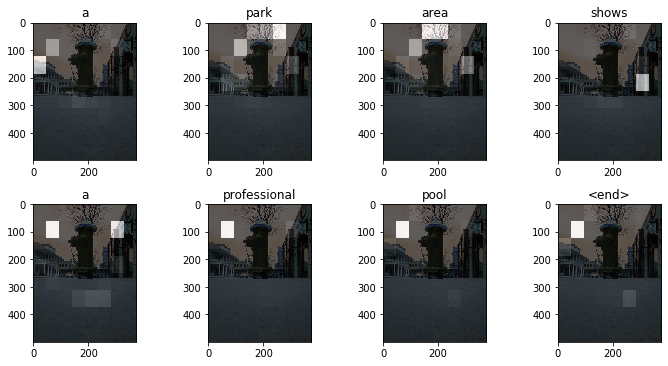

In [93]:
idx = np.random.randint(0, len(img_name_val))
image_path = img_name_val[idx]

real_caption = ' '.join([tokenizer.index_word[i] for i in pad_val[idx] if i not in [0]])
result, attention_plots = evaluate(image_path)

print("Real: {}".format(real_caption))
print("Prediction: {}".format(result))
plot_attention(image_path, result, attention_plots)

## Try the Example Image

Prediction: ['a', 'person', 'surfing', 'with', 'his', 'surfboard', 'on', 'as', 'she', 'stands', 'in', 'the', 'water', 'while', 'looking', 'over', 'the', 'wave', 'while', 'water', 'by', 'forested', 'past', '<end>']


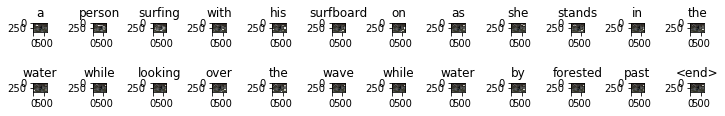

In [95]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image' + image_extension,
                                     origin=image_url)

result, attention_plots = evaluate(image_path)
print('Prediction: {}'.format(result))
plot_attention(image_path, result, attention_plots)